## Семинар 2 "Распознавание рукописных цифр"

ФИО: __Gospodinov Georgy__

В этом задании мы используем нейронную сеть из предыдущего семинара для распознавания рукописных цифр. Также мы исследуем как влияет выбор нелинейности и предобработка данных на качество классификации. 

Чтобы не тратить время на подготовку данных, мы прилагаем готовый код с примером использования для получения обучающей и тестовой выборок. Для запуска скрипта вам понадобится библиотека PyTorch (инструкции по установке можно найти на сайте <a href="http://pytorch.org">pytorch.org</a>)

In [1]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import numpy as np
import sys
from layers import Linear, Sigmoid, NLLLoss, NeuralNetwork # Results from Seminar 1
from IPython.display import clear_output
%matplotlib inline

In [2]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [3]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()

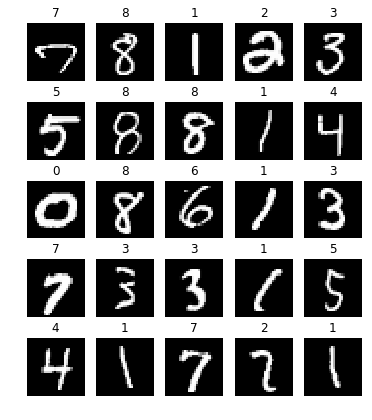

In [4]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

### Часть 1: MNIST
Обучите полносвязную нейронную сеть с архитектурой 784-100-100-10 и сигмоидой в качестве нелинейности. Какую точность классификации удалось получить? Нарисуйте график сходимости на обучающей и тестовой выборках. В качестве темпа обучения (learning rate) возьмите 0.01

In [5]:
def train(train_loader, test_loader, network, epochs, learning_rate, plot=True, verbose=True, loss=None):
    loss = loss or NLLLoss()
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                dLdx = loss.backward()
                network.backward(dLdx)
                network.step(learning_rate)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []    
            for X, y in test_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            if verbose:
                sys.stdout.write('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                            epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                            train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            if plot:
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.plot(train_loss_epochs, label='Train')
                plt.plot(test_loss_epochs, label='Test')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.subplot(1, 2, 2)
                plt.plot(train_accuracy_epochs, label='Train accuracy')
                plt.plot(test_accuracy_epochs, label='Test accuracy')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.show()
    except KeyboardInterrupt:
        pass
    return train_loss_epochs, \
           test_loss_epochs, \
           train_accuracy_epochs, \
           test_accuracy_epochs

In [6]:
network = NeuralNetwork([Linear(784, 100), Sigmoid(),
               Linear(100, 100), Sigmoid(),
               Linear(100, 10)])
loss = NLLLoss()

Epoch 19... (Train/Test) NLL: 0.308/0.302	Accuracy: 0.918/0.918

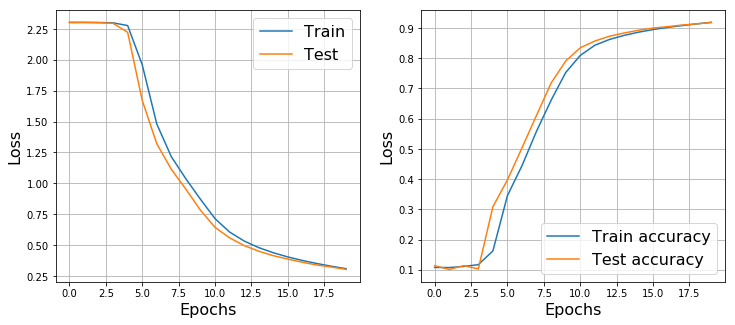

In [7]:
tr_s, ts_s, tr_ac_s, ts_ac_s = train(train_loader, test_loader, network, 20, 0.01)

### Часть 2: Нелинейности

Обучите нейронную сеть с другими нелинейностями: ReLU и ELU. Сравните скорости сходимости и качество классификации с различными функциями активации.

In [8]:
class ReLU:
    def __init__(self):
        pass

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return np.maximum(X, 0)

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        dydX = (self.X >= 0).astype(float)
        return dLdy*dydX

    def step(self, learning_rate):
        pass

In [9]:
class ELU:
    '''
    ELU(x) = x, x > 0; a*(e^x - 1), x <= 0
    '''
    
    def __init__(self, a=1):
        self.a = a

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return X * (X > 0) + self.a * (np.exp(X) - 1) * (X <= 0)
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        X = self.X
        dydX = (X > 0) + self.a * np.exp(X) * (X <= 0)
        return dLdy*dydX

    def step(self, learning_rate):
        pass

In [10]:
network = NeuralNetwork([Linear(784, 100), ReLU(),
               Linear(100, 100), ReLU(),
               Linear(100, 10)])
loss = NLLLoss()
tr_r, ts_r, tr_ac_r, ts_ac_r = train(train_loader, test_loader, network, 20, 0.01, plot=False, verbose=False)

In [11]:
network = NeuralNetwork([Linear(784, 100), ELU(),
               Linear(100, 100), ELU(),
               Linear(100, 10)])
loss = NLLLoss()
tr_e, ts_e, tr_ac_e, ts_ac_e = train(train_loader, test_loader, network, 20, 0.01, plot=False, verbose=False)

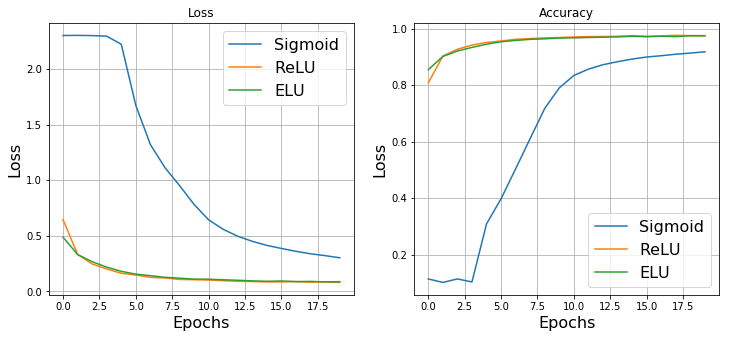

In [12]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(ts_s, label='Sigmoid')
plt.plot(ts_r, label='ReLU')
plt.plot(ts_e, label='ELU')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(ts_ac_s, label='Sigmoid')
plt.plot(ts_ac_r, label='ReLU')
plt.plot(ts_ac_e, label='ELU')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

### HW1 (1 балл): Реализовать Tanh

In [13]:
class Tanh:
    def __init__(self):
        pass

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return np.tanh(self.X)

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        dydX = 1 / np.cosh(self.X) ** 2
        return dLdy*dydX

    def step(self, learning_rate):
        pass

Epoch 19... (Train/Test) NLL: 0.030/0.080	Accuracy: 0.994/0.974

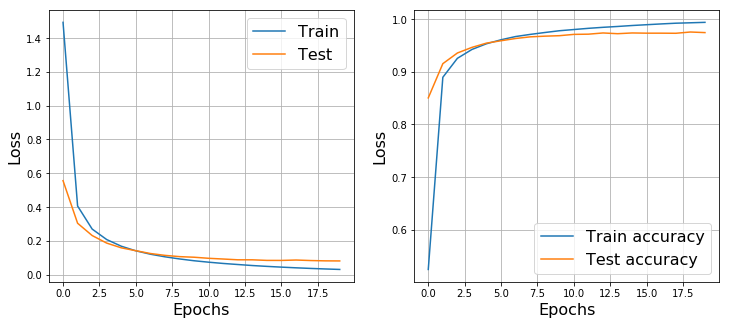

In [14]:
network = NeuralNetwork([Linear(784, 100), Tanh(),
               Linear(100, 100), Tanh(),
               Linear(100, 10)])
loss = NLLLoss()
tr_t, ts_t, tr_ac_t, ts_ac_t = train(train_loader, test_loader, network, 20, 0.01)

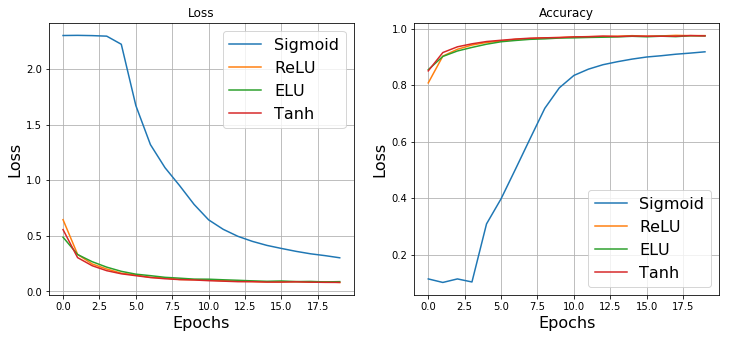

In [15]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(ts_s, label='Sigmoid')
plt.plot(ts_r, label='ReLU')
plt.plot(ts_e, label='ELU')
plt.plot(ts_t, label='Tanh')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(ts_ac_s, label='Sigmoid')
plt.plot(ts_ac_r, label='ReLU')
plt.plot(ts_ac_e, label='ELU')
plt.plot(ts_ac_t, label='Tanh')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

In [16]:
print('sigmoid max test accuracy: {:.4f}'.format(np.max(ts_ac_s)))
print('ReLU    max test accuracy: {:.4f}'.format(np.max(ts_ac_r)))
print('ELU     max test accuracy: {:.4f}'.format(np.max(ts_ac_e)))
print('Tanh    max test accuracy: {:.4f}'.format(np.max(ts_ac_t)))

sigmoid max test accuracy: 0.9180
ReLU    max test accuracy: 0.9763
ELU     max test accuracy: 0.9750
Tanh    max test accuracy: 0.9755


Разница не велика, но ReLU показал себя лучше. Будем использовать его для обучения на аугментированной выборке<br>
(на самом деле просто повезло и от запуска к запуску лучшая функция активации меняется)

In [22]:
score = {}
score['without'] = np.max(ts_ac_t)

### Часть 3: Анализ ошибок

In [17]:
wrong_X = []
correct_y = []
predicted_y = []
logits = []
for X, y in test_loader:
    X = X.view(X.shape[0], -1).numpy()
    y = y.numpy()
    prediction = network.forward(X)
    prediction = np.exp(prediction)
    prediction /= prediction.sum(1, keepdims=True)
    for i in range(len(prediction)):
        if np.argmax(prediction[i]) != y[i]:
            wrong_X.append(X[i])
            correct_y.append(y[i])
            predicted_y.append(np.argmax(prediction[i]))
            logits.append(prediction[i][y[i]])
wrong_X = np.row_stack(wrong_X)
correct_y = np.row_stack(correct_y)[:, 0]
predicted_y = np.row_stack(predicted_y)[:, 0]
logits = np.row_stack(logits)[:, 0]

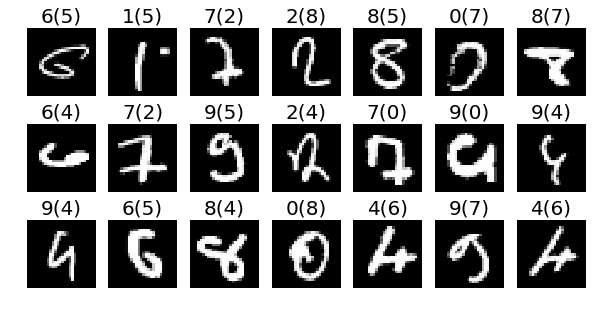

In [18]:
plt.figure(figsize=(10, 5))
order = np.argsort(logits)
for i in range(21):
    plt.subplot(3, 7, i+1)
    plt.imshow(wrong_X[order[i]].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title('{}({})'.format(correct_y[order[i]], predicted_y[order[i]]), fontsize=20)
    plt.axis('off')

### Часть 4: Аугментация (HW, 2 балла)
* Небольшие вращения (-15, 15)
* Случайные сдвиги
* Шум

Какой прирост дают эти аугментации вместе и по отдельности

In [24]:
def LearningWithAugmentation(transform):
    train_dataset = MNIST('.', train=True, download=True, transform=transform)
    test_dataset = MNIST('.', train=False, transform=transform)
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    network = NeuralNetwork([Linear(784, 100), ReLU(),
               Linear(100, 100), ReLU(),
               Linear(100, 10)])
    loss = NLLLoss()
    
    _, _, _, ts_ac = train(train_loader, test_loader, network, 20, 0.01)
    
    X, y = next(iter(train_loader))
    X = X.numpy()
    y = y.numpy()
    
    plt.figure(figsize=(6, 7))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
        plt.title(y[i])
        plt.axis('off')
    plt.show()
    
    return np.max(ts_ac)

#### Вращения

Epoch 19... (Train/Test) NLL: 0.073/0.088	Accuracy: 0.978/0.973

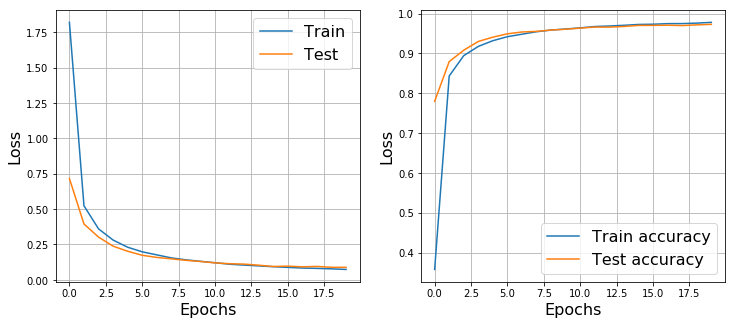

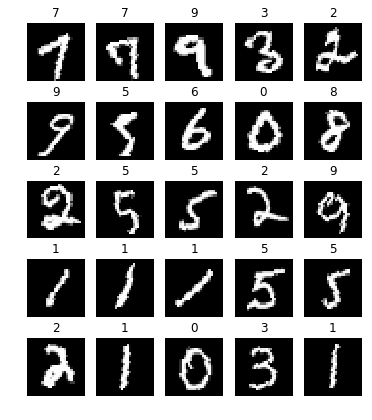

In [25]:
transform = transforms.Compose([
                       transforms.RandomRotation(degrees=(-15,15)),
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])

score['rotation'] = LearningWithAugmentation(transform)

#### Сдвиги

Epoch 19... (Train/Test) NLL: 0.074/0.077	Accuracy: 0.978/0.976

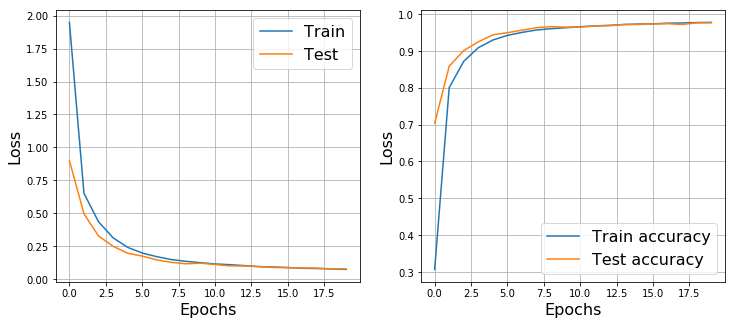

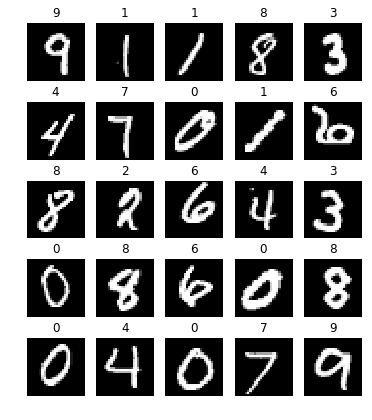

In [26]:
transform = transforms.Compose([
                       transforms.RandomAffine(degrees=0, translate=(0.05,0.05)),
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])

score['shift'] = LearningWithAugmentation(transform)

#### Шум

In [27]:
from PIL import Image

class RandomNoise(object):
    '''
    Add Gaussian Noise with a given scale to the image.
    '''
    def __init__(self, scale):
        self.scale = scale

    def __call__(self, image):
        numpy_image = np.asarray(image, dtype=np.float64)
        
        numpy_image = numpy_image + np.random.normal(scale=self.scale, size=image.size)
        
        return Image.fromarray(numpy_image)

Epoch 19... (Train/Test) NLL: 0.178/0.256	Accuracy: 0.961/0.947

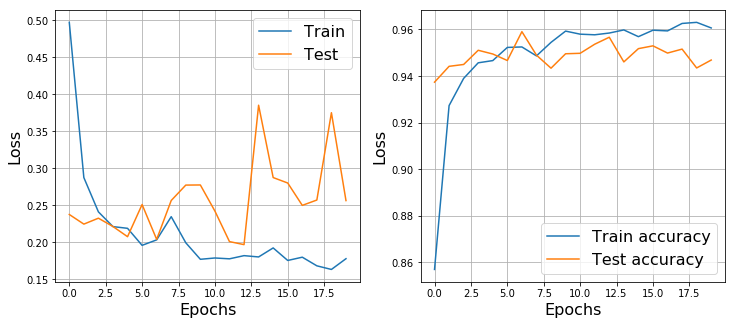

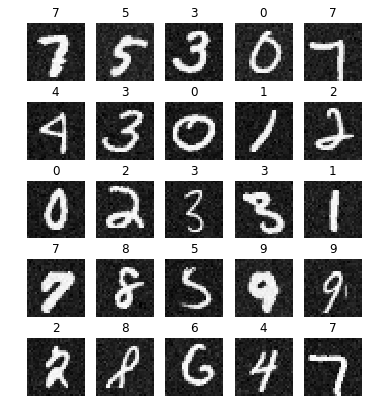

0.9589656549520766

In [28]:
transform = transforms.Compose([
                       RandomNoise(10),
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])

LearningWithAugmentation(transform)

Для Tanh в случае шума все было очень плохо: и с амплитудой шума 10, и с амплитудой 1 качество еле доходило до 0.7, а для ReLU такое хорошее начало! Хоть и переобучение. Попробуем амплитуду шума поменьше.

Epoch 19... (Train/Test) NLL: 0.826/0.951	Accuracy: 0.768/0.727

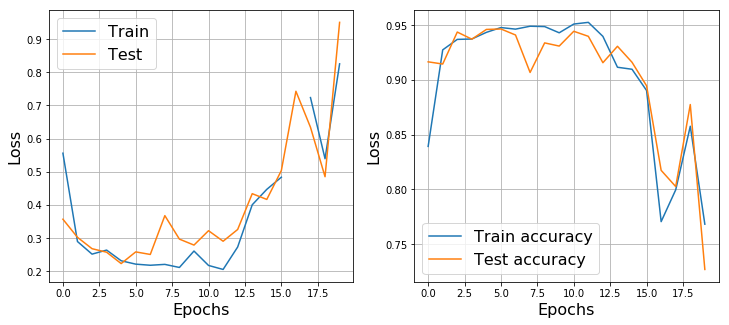

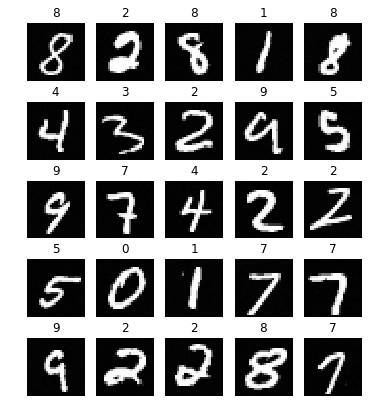

In [29]:
transform = transforms.Compose([
                       RandomNoise(1),
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])

score['noise'] = LearningWithAugmentation(transform)

Лучше шум убрать... В качестве итоговой аугментации попробуем все, кроме шума.

#### Композиция

Epoch 19... (Train/Test) NLL: 0.100/0.095	Accuracy: 0.969/0.970

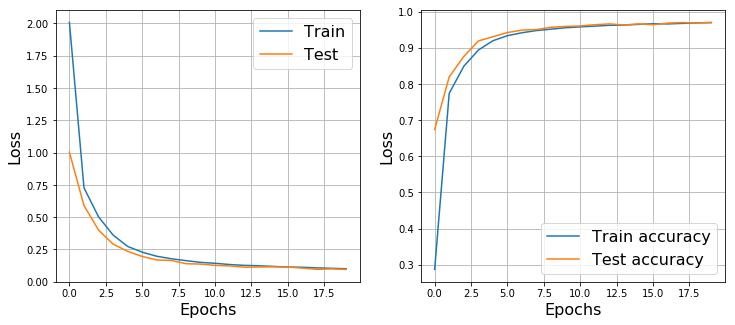

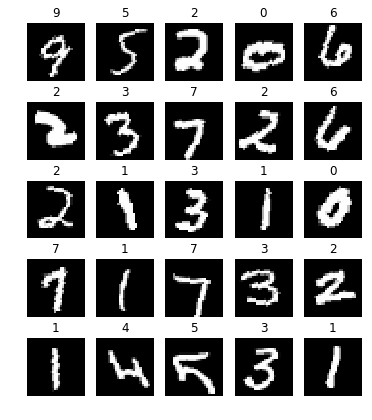

In [31]:
transform = transforms.Compose([
                       transforms.RandomAffine(degrees=(-15,15), translate=(0.05,0.05)),
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])

score['affine'] = LearningWithAugmentation(transform)

#### Сравнение прироста качества

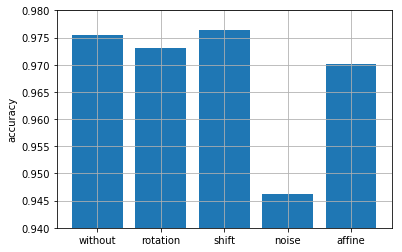

In [36]:
plt.bar(score.keys(), score.values())
plt.grid()
plt.ylim([0.94, 0.98])
plt.ylabel('accuracy')
plt.show()

In [52]:
for aug in score:
    if aug != 'without':
        print('boost with {method}:\t{:10.4f}'.format(score[aug]-score['without'], method=aug))

boost with rotation:	   -0.0025
boost with shift:	    0.0008
boost with noise:	   -0.0293
boost with affine:	   -0.0054


### Часть 5: Выводы
Опишите полученные результаты: как влияют выбор нелинейности и предобработка данных на скорость сходимости и итоговое качество?

Для данной задачи и архитектуры точно не надо использовать сигмоидальную функцию активации.<br>
Выбор из ReLU, ELU, Tanh не имеет значения.<br>
Прирост аугментации практически нулевой. Шум сильно портит картину. Поскольку MNIST не зашумлен, а имеются лишь некоторые "капли", то смысла в такой аугментации нет, сеть только переобучается на шуме.<br>